# MNIST Adversarial Images with TensorFlow

Create adversarial images to fool a MNIST classifier in TensorFlow

## A Tech Challenge & Benchmark

**Backstory**

The original concept of this notebook was based on a Machine Learning (intern) candidate tech challenge from the Toronto startup [500px](https://500px.com).

When I first saw the posting, it was at the beginning of my 3 month career pivot into Deep Learning and I thought this challenge would be a great way for me to benchmark my progress once I get started. You can read more about my career transition journey on [Medium](https://medium.com/towards-data-science/my-3-month-deep-learning-career-pivot-af94cd8d6a31) and a revised/updated version on [LinkedIn]().

Although, I didn't follow through with providing the entire final output of the challenge, I'm quite satisfied that I've successfully completed it and consider it a demonstration of my current knowledge and capability.

Prior to starting this challenge, I completed [Fast.ai: Practical Deep Learning - Part 1](http://course.fast.ai/). Read through my blog post to see my reading material - [Deep Learning Reading List](http://jasonicarter.github.io/deep-learning-reading-list).

**The Challenge (summarized)**

Create adversarial images to fool a MNIST classifier in TensorFlow.
1. Learn how adversarial examples are created. For example, “Breaking Linear Classifiers on ImageNet” gives a good overview on the subject.
2. Install Tensorflow
3. Follow “Deep MNIST for Experts” tutorial to get the MNIST classifier running.
4. Expand the code from the previous step to generate adversarial images. Specifically, pick 10 images of digit ‘2’ which are correctly classified as ‘2’ by the trained model and modify them so the network incorrectly classifies them as 6.
5. Generate adversarial examples and save them as a single image containing a grid of 10 rows and 3 columns. The rows correspond to the selected examples of ‘2’. The columns are original image, delta and adversarial image. Provide link to the resulting image.
6. Make your code clean and readable. Add comments where needed.

## Approach

1. Read basic need-to-know about adversarial images
2. Get data to be used throughout notebook
3. Build a simple CNN (test model)
4. Train it on MNIST 
5. Show model classification of 10 handwritten 2s
6. Create adversarial image to classify 2s as 6s
7. Test adversarial image with original model (in step 2)

## Data

In [1]:
# Dependencies for entire notebook here
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please write your own downloading logic.


Instructions for updating:
Please use tf.data to implement this functionality.


Extracting /tmp/data/train-images-idx3-ubyte.gz


Instructions for updating:
Please use tf.data to implement this functionality.


Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.


Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Take a look the training data
print('Training.images shape: ', mnist.train.images.shape)
print('Training.labels shape: ', mnist.train.labels.shape)
print('Shape of an image: ', mnist.train.images[0].shape)
print('Example label: ', mnist.train.labels[0])


Training.images shape:  (55000, 784)
Training.labels shape:  (55000, 10)
Shape of an image:  (784,)
Example label:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


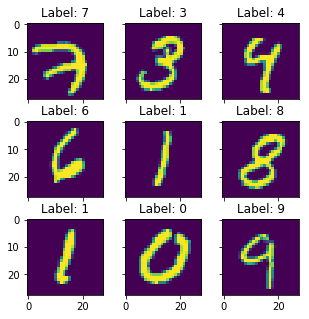

In [4]:
# Review a few images
image_list = mnist.train.images[0:9]
image_list_labels = mnist.train.labels[0:9]

# https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#imagegrid
fig = plt.figure(1, (5., 5.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for i in range(len(image_list)):
    image = image_list[i].reshape(28,28)
    grid[i].imshow(image)
    grid[i].set_title('Label: {0}'.format(image_list_labels[i].argmax()))

plt.show()

## Benchmark CNN (for testing)

Based on challenge requirements, building model using tensorflow low-level API

In [5]:
# To run nicely in jupyter notebook
sess = tf.InteractiveSession()

In [6]:
# Functions for creating weights and biases
# https://www.tensorflow.org/get_started/mnist/pros
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [7]:
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Benchmark model to be used for testing classification on real images with and without noise

In [8]:
# y = (Wx +b)
# https://www.tensorflow.org/get_started/mnist/pros

# Input layer
x_image = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# Conv layer 1 - 32x5x5
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv layer 2 - 64x5x5
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Flatten - keras 'flatten'
x_flat = tf.reshape(x_pool2, [-1, 7*7*64])

# Dense fully connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024]) # max pooling reduced image to 7x7
b_fc1 = bias_variable([1024])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2

In [9]:
# Probabilities - output from model (not the same as logits)
y = tf.nn.softmax(y_conv)

In [10]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [11]:
# Setup to test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
# Initilize all global variables
sess.run(tf.global_variables_initializer())

In [13]:
# Train model
# Run once to get the model to a good confidence level
for i in range(1000):
    batch = mnist.train.next_batch(100)
    if i%200 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})


step 0, training accuracy 0.15


step 200, training accuracy 0.89


step 400, training accuracy 0.92


In [14]:
print(batch.shape)
print(batch[1].shape)


AttributeError: 'tuple' object has no attribute 'shape'

In [15]:
# Run trained model against test data
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images[0:500], 
                                                  y_: mnist.test.labels[0:500], keep_prob: 1.0}))


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [16]:
def create_predictions(image_list):
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pct_list = np.zeros(len(image_list))
    pred_list = np.argmax(prob, axis=1)
    for i in range(len(prob)):
        pct_list[i] = prob[i][pred_list[i]]
        
    return pred_list, pct_list


In [17]:
def plot_predictions(image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(prob[i]) # for mnist index == classification
        pct_list[i] = prob[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image)
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None


In [18]:
# Get 10 2s [:,2] from top 500 [0:500], nonzero returns tuple, get index[0], then first 10 [0:10]
index_of_2s = np.nonzero(mnist.test.labels[0:500][:,2])[0][0:10]
x_batch = mnist.test.images[index_of_2s]

In [19]:
plot_predictions(x_batch)

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

All above 2s are correctly classified, although at varying degrees of certainty (mostly above 95%)

## Adversarial Images

Expand on benchmark model using low-level API. Create adversarial image of a 2 to be misclassified as a 6

In [20]:
# Mostly inspired by:
# https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture
def create_plot_adversarial_images(x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for _ in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image, keep_prob: 1.0}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
        
        # Create darray of 3 images - orig, noise/delta, adversarial
        x_image = np.reshape(x_adv, (1, 784))
        img_adv_list = original_image
        img_adv_list = np.append(img_adv_list, dydx[0], axis=0)
        img_adv_list = np.append(img_adv_list, x_image, axis=0)

        # Print/plot images and return probabilities
        probs = plot_predictions(img_adv_list, output_probs=output_probs, adversarial=True)
        probs_per_step.append(probs) if output_probs else None
    
    return probs_per_step


In [21]:
def create_adversarial_image(x_image, y_label, lr=0.1, n_steps=1):
    
    original_image = x_image
    probs_per_step = []
    
    # Calculate loss, derivative and create adversarial image
    # https://www.tensorflow.org/versions/r0.11/api_docs/python/train/gradient_computation
    loss =  tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=y_conv)
    deriv = tf.gradients(loss, x)
    image_adv = tf.stop_gradient(x - tf.sign(deriv)*lr/n_steps)
    image_adv = tf.clip_by_value(image_adv, 0, 1) # prevents -ve values creating 'real' image
    
    for i in range(n_steps):
        # Calculate derivative and adversarial image
        dydx = sess.run(deriv, {x: x_image, keep_prob: 1.0}) # can't seem to access 'deriv' w/o running this
        x_adv = sess.run(image_adv, {x: x_image, keep_prob: 1.0})
        x_image = np.reshape(x_adv, (1, 784))
        
    label, prob = create_predictions(x_image)
    return x_image, label, prob


In [22]:
# Pick a random 2 image from first 1000 images 
# Create adversarial image and with target label 6
index_of_2s = np.nonzero(mnist.test.labels[0:1000][:,2])[0]
rand_index = np.random.randint(0, len(index_of_2s))
image_norm = mnist.test.images[index_of_2s[rand_index]]
image_norm = np.reshape(image_norm, (1, 784))
label_adv = [0,0,0,0,0,0,1,0,0,0] # one hot encoded, adversarial label 6


In [23]:
def create_specific_adversarial_image(originNumber, destinationNumber, n_steps=10):
    index_of_number = np.nonzero(mnist.test.labels[0:1000][:,originNumber])[0]
    rand_index = np.random.randint(0, len(index_of_number))
    image_norm = mnist.test.images[index_of_number[rand_index]]
    image_norm = np.reshape(image_norm, (1, 784))    
    label_adv = np.zeros(10).astype(int) # one hot encoded
    label_adv[destinationNumber] = 1;
    adv_image, label, prob = create_adversarial_image(image_norm, label_adv, lr=0.2, n_steps=n_steps)
    return adv_image, label, prob

In [24]:
def generate_trainSet():
    number_of_examples_per_number = 1;
    original_number = np.zeros(shape=(1, 1))
    original_number = np.delete(original_number, 0, 0)
    target_number = np.zeros(shape=(1, 10))
    target_number = np.delete(target_number, 0, 0)
    prob_list = np.zeros(shape=(1, 1))
    prob_list = np.delete(prob_list, 0, 0)
    adv_img_list = np.zeros(shape=(1, 784))
    adv_img_list = np.delete(adv_img_list, 0, 0)
    for origin in range(3):
        for p in range(number_of_examples_per_number):
            for target in range(3):
                if origin != target:
                    prob = 0
                    label = origin
                    n_steps = 10
                    while prob < 0.9 or label != target:
                        adv_image, label, prob = create_specific_adversarial_image(origin, target, n_steps)
                        prob = prob[0]
                        label = label[0]
                        print("-", end="", flush=True)
                        
                        #print((origin, target, label, prob, n_steps), end="", flush=True)                        
                        #print(" X ")
                        n_steps = n_steps + 2
                    original_number = np.append(original_number, origin)
                    target_to_add = np.zeros(shape=(1,10))
                    target_to_add[0][target] = 1 #to vectorize the labeling
                    target_number = np.concatenate((target_number, target_to_add), axis=0)
                    prob_list = np.append(prob_list, prob)
                    #the action of concation can be i,proved
                    adv_img_list = np.concatenate((adv_img_list, adv_image), axis=0)
                    print("|", end="", flush=True)
        print("Number")            
        #print(original_number, target_number, prob_list)
    return original_number, target_number, prob_list, adv_img_list


def generate_adversarial_and_save():
    original_number, target_number, prob_list, adv_img_list = generate_trainSet()
    np.save('original_number.npy', original_number)
    np.save('target_number.npy', target_number)
    np.save('prob_list.npy', prob_list)
    np.save('adv_img_list.npy', adv_img_list)
    
    
def load_saved_adversarial():    
    original_number = np.load('original_number.npy')
    target_number = np.load('target_number.npy')
    prob_list = np.load('prob_list.npy')
    adv_img_list = np.load('adv_img_list.npy')
    return original_number, target_number, prob_list, adv_img_list


In [25]:
original_number, target_number, prob_list, adv_img_list = generate_trainSet()



NameError: name 'sess' is not defined

In [26]:
# uniting and shuffeling between adv inputs and benign
# creating labels as 2d array which [0,1] is adv
number_of_adv_images = adv_img_list.shape[0]
adv_label = np.zeros(number_of_adv_images)
adv_label = np.c_[adv_label, np.ones(number_of_adv_images)]

number_of_benign = 1000
benign_label = np.ones(number_of_benign)
benign_label = np.c_[benign_label, np.zeros(number_of_benign)]
# uniting adv and benign
united_labels = np.concatenate((adv_label, benign_label), axis=0)
united_images = np.concatenate((adv_img_list, mnist.train.images[0:number_of_benign]), axis=0)
united_images_and_labels = np.c_[united_images, united_labels]
np.random.shuffle(united_images_and_labels)
#add precondition
images_data, labels_data = np.hsplit(united_images_and_labels, [united_images_and_labels.shape[1]-2])
train_size = 700
image_train_data, image_test_data = np.split(images_data, [train_size])
label_train_data, label_test_data = np.split(labels_data, [train_size])

NameError: name 'adv_img_list' is not defined

In [27]:
print(image_train_data.shape)


NameError: name 'image_train_data' is not defined

In [28]:
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
y_ = tf.placeholder(tf.float32, shape=[None, 2], name='y_')


In [29]:
# modified nn based on original

# Input layer
x_image_new = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# Conv layer 1 - 32x5x5 - using same weights and biases as the pretrained
# W_conv1 = weight_variable([5, 5, 1, 32])
# b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image_new, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv detector layer 1  - 32x5x5
W_conv1_detector = weight_variable([5, 5, 32, 32])
b_conv1_detector = bias_variable([32])
x_conv1_detector = tf.nn.relu(conv2d(x_pool1, W_conv1_detector) + b_conv1_detector)
x_pool1_detector = max_pooling_2x2(x_conv1_detector)

# Conv layer 2 - 64x5x5
# W_conv2 = weight_variable([5, 5, 96, 64])
# b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# stacking conv2 output and x_pool1 detector output
conv_detector_2_input = tf.concat([x_conv2, x_pool1], 3)


In [30]:

# Conv detector layer 2 - 64x5x5
W_conv2_detector = weight_variable([5, 5, 96, 64])
b_conv2_detector = bias_variable([64])
x_conv2_detector = tf.nn.relu(conv2d(conv_detector_2_input, W_conv2_detector) + b_conv2_detector)
x_pool2_detector = max_pooling_2x2(x_conv2_detector)
# Flatten - keras 'flatten'
pool_shape = x_pool2_detector.shape
shape_size = (pool_shape[1]*pool_shape[2]*pool_shape[3]).value
x_flat_detector = tf.reshape(x_pool2_detector, [-1, shape_size])


In [31]:

W_fc1_detector = weight_variable([shape_size, 1024]) # max pooling reduced image to 7x7


In [32]:
b_fc1_detector = bias_variable([1024])


In [33]:

x_fc1_detector = tf.nn.relu(tf.matmul(x_flat_detector, W_fc1_detector) + b_fc1_detector)


In [34]:

# Regularization with dropout
keep_prob_detector = tf.placeholder(tf.float32)
x_fc1_drop_detector = tf.nn.dropout(x_fc1, keep_prob_detector)


In [35]:

# Classification layer
W_fc2_detector = weight_variable([1024, 2])
b_fc2_detector = bias_variable([2])
y_conv= tf.matmul(x_fc1_drop_detector, W_fc2_detector) + b_fc2_detector


In [36]:
# Probabilities - output from model (not the same as logits)
# CHANGE!!-----------------------------------------------------------------
y = tf.nn.softmax(y_conv)

In [37]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
# add variables to optimize here:
var_list = [W_conv1_detector, W_conv2_detector, W_fc2_detector]
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy, var_list=var_list)

In [38]:
# Setup to test accuracy of model
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [39]:
sess.close()
sess = tf.InteractiveSession()

NameError: name 'sess' is not defined

In [40]:
# Initilize all global variables
# might want to remove
sess.run(tf.global_variables_initializer())

NameError: name 'sess' is not defined

In [41]:
# Train model
# Run once to get the model to a good confidence level
batch_size = 100
batch_index = 0
for i in range(100):
    if(batch_size>=image_train_data.shape[0]):
        print("reached limit of train data current index: ", batch_index, "data size: ", train_data.shape[0])
        break
    batch_image = image_train_data[batch_index: (batch_index + batch_size)]
    batch_label = label_train_data[batch_index: (batch_index + batch_size)]
    if i%20 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch_image, y_: batch_label, keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))

    train_step.run(feed_dict={x: batch_image, y_: batch_label, keep_prob: 0.4})
    batch_index = batch_index + batch_size


NameError: name 'image_train_data' is not defined

In [42]:
batch_image = image_train_data[0: 100]
print(batch_image[0].shape)

NameError: name 'image_train_data' is not defined

In [43]:
# Run trained model against test data
print("test accuracy %g"%accuracy.eval(feed_dict={x: test_data[0], 
                                                  y_: test_data[1], keep_prob: 1.0}))

NameError: name 'test_data' is not defined